In [ ]:
%load_ext autoreload
%autoreload 2

# Add the project directory to our module path
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [39]:
# Import the rest of our modules
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

%matplotlib inline

# Import py files
from src import cm_class_LRM as LRM # Logistic Regression Model Class
from src import cm_class_KNN as KNN # K-Nearest Neighbor Model Class
from src import cm_functions_balancing as cmbal
from src import cm_functions_preprocessing as cmpre
from src import cm_functions_tuning as cmtune

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Classifier Libraries
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier

# Other Libraries
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, precision_score
from collections import Counter
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils import resample

# Create paths to folders in repo
data_folder = '../../data/'
src_folder = '../../src/'

In [3]:
df=pd.read_csv('../../data/initial_clean_lc', index_col=[0])
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Creating 3 datasets to work with

In [4]:
# X2 adds total_charge
# X3 adds avge_charge
X, X2, X3, y = cmpre.prepare_dataset(df)
X3.head()


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,avg_charge_per_day
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.590313
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.553645
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.454672
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.795238
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.694533


# MODEL 1,X

#### NO PARAMETERS

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .25)

In [55]:
# create kfolds object
kf = KFold(n_splits = 5, shuffle=True, random_state = 42)

In [57]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])
    mu_performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(),AdaBoostClassifier(),
               GradientBoostingClassifier()]

    for clf in classifiers:
        train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, 
                                   estimator=clf, scoring=recall,cv=10)

        # Predict
        y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

        conf_matrix = confusion_matrix(y_val,y_pred)

        # Store results
        performance.loc[clf.__class__.__name__+'_default',
                        ['Train_Recall','Test_Recall','Test_Specificity']] = [
            train_cv.mean(),
            recall_score(y_val,y_pred),
            conf_matrix[0,0]/conf_matrix[0,:].sum()
        ]
    mu_performance = pd.concat([mu_performance,performance])
    print(mu_performance)


                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.927389       0.675         0.919048
RandomForestClassifier_default          0.95121      0.7375          0.97381
AdaBoostClassifier_default             0.859443      0.5875         0.883333
GradientBoostingClassifier_default     0.918702         0.7          0.97619
                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.929488    0.706667         0.924706
RandomForestClassifier_default         0.952791    0.786667         0.962353
AdaBoostClassifier_default              0.85969    0.586667         0.917647
GradientBoostingClassifier_default     0.928954    0.733333         0.957647
                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.928053    0.691176         0.891204
RandomForestClassifier_default         0.948504    0.764706         0.976852

# MODEL 1,X2

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X2,y, random_state=42, test_size = .25)

In [59]:
# create kfolds object
kf = KFold(n_splits = 5, shuffle=True, random_state = 42)

In [60]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])
    mu_performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(),AdaBoostClassifier(),
               GradientBoostingClassifier()]

    for clf in classifiers:
        train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, 
                                   estimator=clf, scoring=recall,cv=10)

        # Predict
        y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

        conf_matrix = confusion_matrix(y_val,y_pred)

        # Store results
        performance.loc[clf.__class__.__name__+'_default',
                        ['Train_Recall','Test_Recall','Test_Specificity']] = [
            train_cv.mean(),
            recall_score(y_val,y_pred),
            conf_matrix[0,0]/conf_matrix[0,:].sum()
        ]
    mu_performance = pd.concat([mu_performance,performance])
    print(mu_performance)

                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.951788      0.8375         0.942857
RandomForestClassifier_default         0.953525         0.8         0.997619
AdaBoostClassifier_default             0.882104      0.6625         0.919048
GradientBoostingClassifier_default     0.932639       0.825         0.995238
                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.953383    0.813333         0.941176
RandomForestClassifier_default         0.950476        0.84         0.992941
AdaBoostClassifier_default             0.884139    0.773333         0.931765
GradientBoostingClassifier_default     0.936523    0.826667         0.995294
                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default          0.94559    0.823529         0.949074
RandomForestClassifier_default         0.947337    0.823529         0.997685

# MODEL 1,X3

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X3,y, random_state=42, test_size = .25)

In [62]:
# create kfolds object
kf = KFold(n_splits = 5, shuffle=True, random_state = 42)

In [63]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])
    mu_performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(),AdaBoostClassifier(),
               GradientBoostingClassifier()]

    for clf in classifiers:
        train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, 
                                   estimator=clf, scoring=recall,cv=10)

        # Predict
        y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

        conf_matrix = confusion_matrix(y_val,y_pred)

        # Store results
        performance.loc[clf.__class__.__name__+'_default',
                        ['Train_Recall','Test_Recall','Test_Specificity']] = [
            train_cv.mean(),
            recall_score(y_val,y_pred),
            conf_matrix[0,0]/conf_matrix[0,:].sum()
        ]
    mu_performance = pd.concat([mu_performance,performance])
    print(mu_performance)

                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.930874       0.725         0.914286
RandomForestClassifier_default         0.957027        0.75          0.97619
AdaBoostClassifier_default             0.853636      0.5625         0.895238
GradientBoostingClassifier_default     0.922772      0.6875         0.966667
                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default          0.91956        0.68         0.936471
RandomForestClassifier_default          0.95222    0.786667         0.971765
AdaBoostClassifier_default             0.857915        0.56         0.910588
GradientBoostingClassifier_default     0.924871        0.72             0.96
                                   Train_Recall Test_Recall Test_Specificity
DecisionTreeClassifier_default         0.928056    0.661765         0.912037
RandomForestClassifier_default         0.948514    0.735294         0.974537

# MODEL 2,X2 GRADIENTBOOST

#### Round 1 StandardScaler

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X2,y, random_state=42, test_size = .25)

In [93]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    clf = GradientBoostingClassifier(
        loss = 'exponential', 
        learning_rate = 0.01,  
        random_state = 15)

    train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, estimator=clf, scoring=recall,cv=10)

    # Predict
    y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

    conf_matrix = confusion_matrix(y_val,y_pred)

    # Store results
    performance.loc['GBC_exp_lr0.01',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_val,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]
    print(performance)

               Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01     0.844865        0.85         0.921429
               Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01     0.861288    0.826667         0.945882
               Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01     0.847881    0.823529         0.944444
               Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01     0.834612         0.9         0.932558
               Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01     0.851799    0.861538           0.9447


In [90]:
X_train_ss, X_test_ss = cmpre.ss_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)
    
gb = GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, random_state = 42)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_ss))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_ss))}')

Train: 0.8527777777777777
Test:  0.8780487804878049


In [95]:
param_grid = {
    "loss":["exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    }

clf = GradientBoostingClassifier(random_state=15)

search = GridSearchCV(estimator=clf,param_grid=param_grid,n_jobs=-1,scoring='recall')

# Train search object
search.fit(X_train_resampled, y_train_resampled)

# Get best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

Best parameters: 

 {'learning_rate': 0.2, 'loss': 'exponential'} 



#### Round 2

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X2,y, random_state=42, test_size = .25)

In [123]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    clf = GradientBoostingClassifier(
        loss = 'exponential', 
        learning_rate = 0.2,  
        random_state = 15)

    train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, estimator=clf, scoring=recall,cv=10)

    # Predict
    y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

    conf_matrix = confusion_matrix(y_val,y_pred)

    # Store results
    performance.loc['GBC_exp_lr0.2_ss',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_val,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]
    print(performance)

                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_ss     0.952984      0.8125                1
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_ss     0.952258    0.853333         0.997647
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_ss     0.966656    0.838235         0.997685
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_ss     0.951533         0.9         0.993023
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_ss     0.953165    0.861538                1


In [125]:
X_train_ss, X_test_ss = cmpre.ss_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)
    
gb = GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.2, random_state = 15)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_ss))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_ss))}')

Train: 0.8659217877094972
Test:  0.864


#### minmax scaler

In [126]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.mm_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    clf = GradientBoostingClassifier(
        loss = 'exponential', 
        learning_rate = 0.2,  
        random_state = 15)

    train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, estimator=clf, scoring=recall,cv=10)

    # Predict
    y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

    conf_matrix = confusion_matrix(y_val,y_pred)

    # Store results
    performance.loc['GBC_exp_lr0.2_mm',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_val,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]
    print(performance)

                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_mm     0.954718         0.8         0.995238
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_mm     0.947589    0.853333         0.997647
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_mm     0.963729    0.838235                1
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_mm     0.951533         0.9         0.997674
                 Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.2_mm     0.952597    0.861538         0.997696


In [127]:
X_train_mm, X_test_mm = cmpre.mm_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_mm, y_train)
    
gb = GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.02, random_state = 15)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_mm))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_mm))}')

Train: 0.8519553072625698
Test:  0.88


In [107]:
param_grid = {
    "loss":["exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    }

clf = GradientBoostingClassifier(random_state=15)

search = GridSearchCV(estimator=clf,param_grid=param_grid,n_jobs=-1,scoring='recall')

# Train search object
search.fit(X_train_resampled, y_train_resampled)

# Get best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

Best parameters: 

 {'learning_rate': 0.2, 'loss': 'exponential', 'min_samples_split': 0.13636363636363638} 



In [108]:
X_train_ss, X_test_ss = cmpre.ss_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)

param_grid = {
    "loss":["exponential"],
    "learning_rate": [0.2],
    "min_samples_split": [0.13636363636363638],
    "min_samples_leaf": np.linspace(0.1, 0.5, 12)
    }

clf = GradientBoostingClassifier(random_state=15)

search = GridSearchCV(estimator=clf,param_grid=param_grid,n_jobs=-1,scoring='recall')

# Train search object
search.fit(X_train_resampled, y_train_resampled)

# Get best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

Best parameters: 

 {'learning_rate': 0.2, 'loss': 'exponential', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638} 



In [128]:
X_train_ss, X_test_ss = cmpre.ss_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)

param_grid = {
    "loss":["exponential", "deviance"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    }

clf = GradientBoostingClassifier(random_state=15)

search = GridSearchCV(estimator=clf,param_grid=param_grid,n_jobs=-1,scoring='recall')

# Train search object
search.fit(X_train_resampled, y_train_resampled)

# Get best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

Best parameters: 

 {'learning_rate': 0.2, 'loss': 'exponential', 'min_samples_leaf': 0.1, 'min_samples_split': 0.3545454545454546} 



In [112]:
X_train_mm, X_test_mm = cmpre.mm_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_mm, y_train)

param_grid = {
    "loss":["exponential", "deviance"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.1],
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    }

clf = GradientBoostingClassifier(random_state=15)

search = GridSearchCV(estimator=clf,param_grid=param_grid,n_jobs=-1,scoring='recall')

# Train search object
search.fit(X_train_resampled, y_train_resampled)

# Get best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

Best parameters: 

 {'learning_rate': 0.2, 'loss': 'deviance', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1} 



#### Round 3

- MinMaxScaler
- {'learning_rate': 0.2, 'loss': 'deviance', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1} 

In [120]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.mm_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    clf = GradientBoostingClassifier(loss = 'deviance', 
                                     learning_rate = 0.2,
                                     min_samples_leaf= 0.1, 
                                     min_samples_split= 0.1,
                                     random_state = 15)

    train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, estimator=clf, scoring=recall,cv=10)

    # Predict
    y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

    conf_matrix = confusion_matrix(y_val,y_pred)

    # Store results
    performance.loc['GBC_dev_lr0.2_msl0.1_mss0.1_mm',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_val,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]
    print(performance)

                               Train_Recall Test_Recall Test_Specificity
GBC_dev_lr0.2_msl0.1_mss0.1_mm     0.928004      0.7625          0.97381
                               Train_Recall Test_Recall Test_Specificity
GBC_dev_lr0.2_msl0.1_mss0.1_mm     0.931266        0.84         0.974118
                               Train_Recall Test_Recall Test_Specificity
GBC_dev_lr0.2_msl0.1_mss0.1_mm     0.949102    0.838235         0.988426
                               Train_Recall Test_Recall Test_Specificity
GBC_dev_lr0.2_msl0.1_mss0.1_mm      0.92876         0.9         0.967442
                               Train_Recall Test_Recall Test_Specificity
GBC_dev_lr0.2_msl0.1_mss0.1_mm     0.927984    0.815385         0.965438


In [121]:
X_train_mm, X_test_mm = cmpre.mm_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_mm, y_train)
    
gb = GradientBoostingClassifier(loss = 'deviance', 
                                     learning_rate = 0.2,
                                     min_samples_leaf= 0.1, 
                                     min_samples_split= 0.1,
                                     random_state = 15)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_mm))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_mm))}')

Train: 0.840782122905028
Test:  0.856


# MODEL 3,X2 GRADIENTBOOST

#### Round 1 
- StandardScaler
- {'learning_rate': 0.2, 'loss': 'exponential', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638} 
- {'learning_rate': 0.2, 'loss': 'exponential', 'min_samples_leaf': 0.1, 'min_samples_split': 0.3545454545454546} 

In [136]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    clf = GradientBoostingClassifier(
        loss = 'exponential', 
        learning_rate = 0.01,
        min_samples_leaf = 0.1,
        min_samples_split = 0.13636363636363638,
        random_state = 15)

    train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, estimator=clf, scoring=recall,cv=10)

    # Predict
    y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

    conf_matrix = confusion_matrix(y_val,y_pred)

    # Store results
    performance.loc['GBC_exp_lr0.01_msl0.1_mss0.136_ss',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_val,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]
    print(performance)

                                  Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01_msl0.1_mss0.136_ss      0.87044        0.85         0.857143
                                  Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01_msl0.1_mss0.136_ss     0.868866    0.853333         0.884706
                                  Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01_msl0.1_mss0.136_ss     0.869532    0.838235          0.87037
                                  Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01_msl0.1_mss0.136_ss       0.8539         0.9         0.869767
                                  Train_Recall Test_Recall Test_Specificity
GBC_exp_lr0.01_msl0.1_mss0.136_ss     0.863505    0.876923         0.880184


In [137]:
X_train_ss, X_test_ss = cmpre.ss_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)
    
gb = GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, 
                                min_samples_leaf = 0.1, min_samples_split = 0.13636363636363638,
                                random_state = 15)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_ss))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_ss))}')

Train: 0.8631284916201117
Test:  0.888


# AGGREGATING DATASET MORE

In [139]:
X, X4, y = cmpre.prepare_dataset(df)
X4.pop("state")
X4.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,avg_charge_per_day,total_minutes,avg_min_per_day,total_calls,avg_calls_per_day
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56,0.590313,717.2,5.603125,303,2.367188
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24,0.553645,625.2,5.842991,332,3.102804
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29,0.454672,539.4,3.937226,333,2.430657
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80,0.795238,564.8,6.723810,255,3.035714
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09,0.694533,512.0,6.826667,359,4.786667


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X4,y, random_state=42, test_size = .25)

# Model 4, X4

In [141]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_) 
    plt.yticks(np.arange(n_features), X_train.columns.values, fontsize = 12) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Model Feature Importance', fontsize = 20)

                     Train_Recall Test_Recall Test_Specificity
GBC_X4_exp_lr0.01_ss     0.845443      0.8375         0.921429
                     Train_Recall Test_Recall Test_Specificity
GBC_X4_exp_lr0.01_ss     0.858364    0.826667         0.948235
                     Train_Recall Test_Recall Test_Specificity
GBC_X4_exp_lr0.01_ss       0.8473    0.823529         0.944444
                     Train_Recall Test_Recall Test_Specificity
GBC_X4_exp_lr0.01_ss     0.839875         0.9         0.932558
                     Train_Recall Test_Recall Test_Specificity
GBC_X4_exp_lr0.01_ss     0.854138    0.861538         0.940092


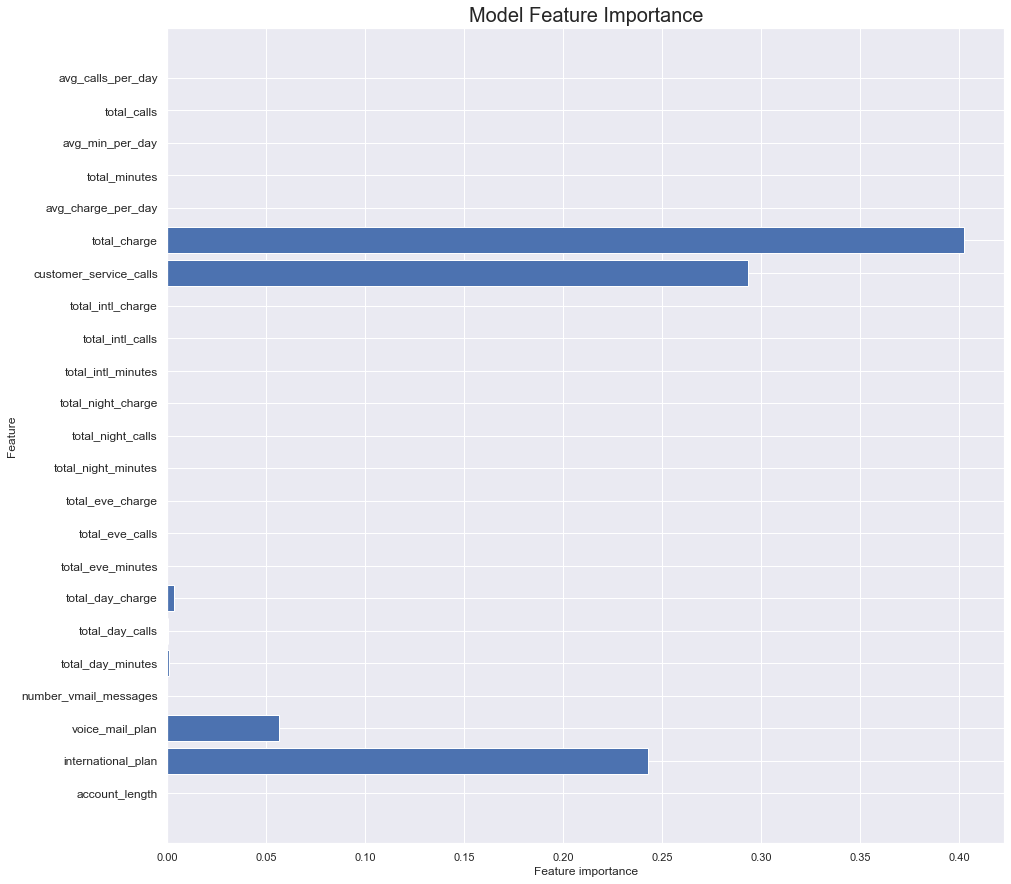

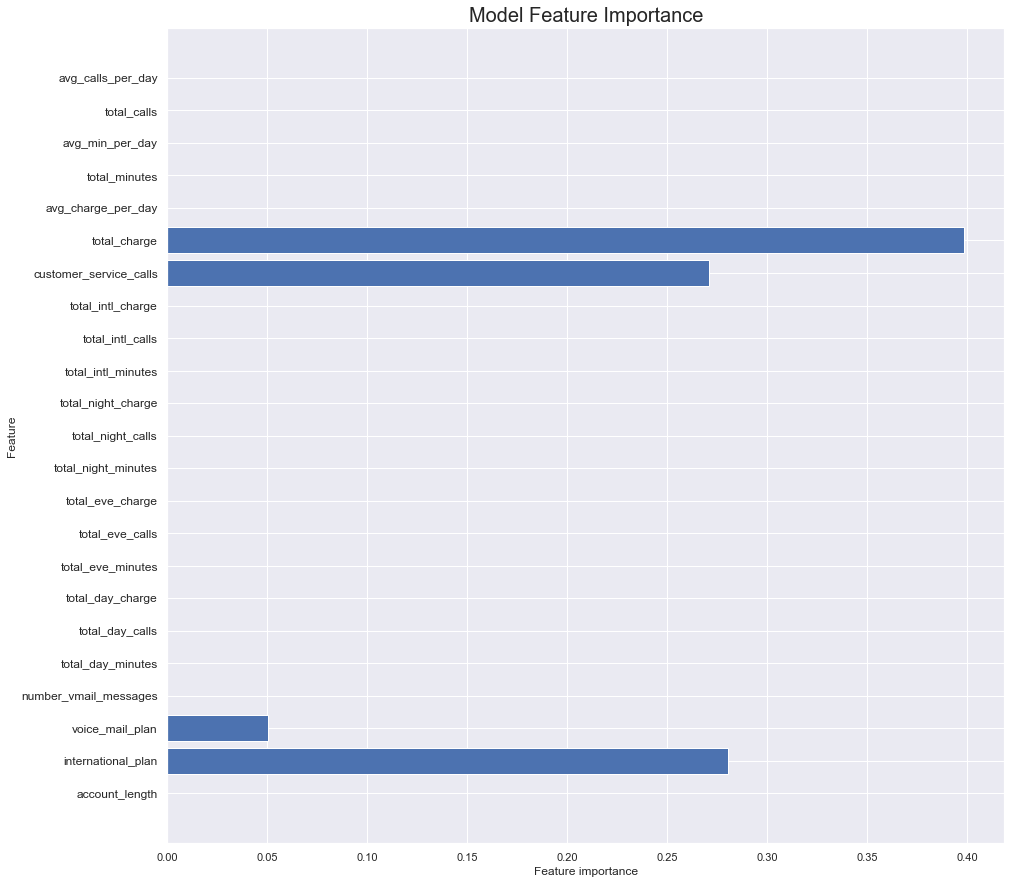

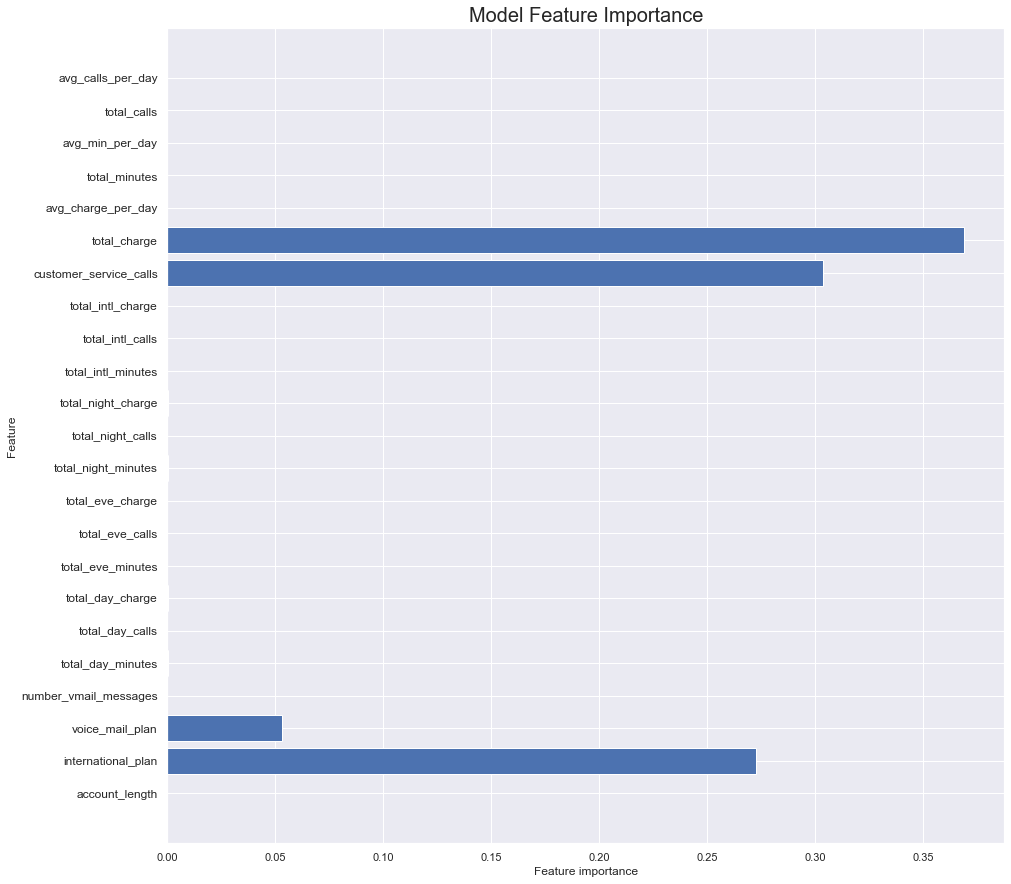

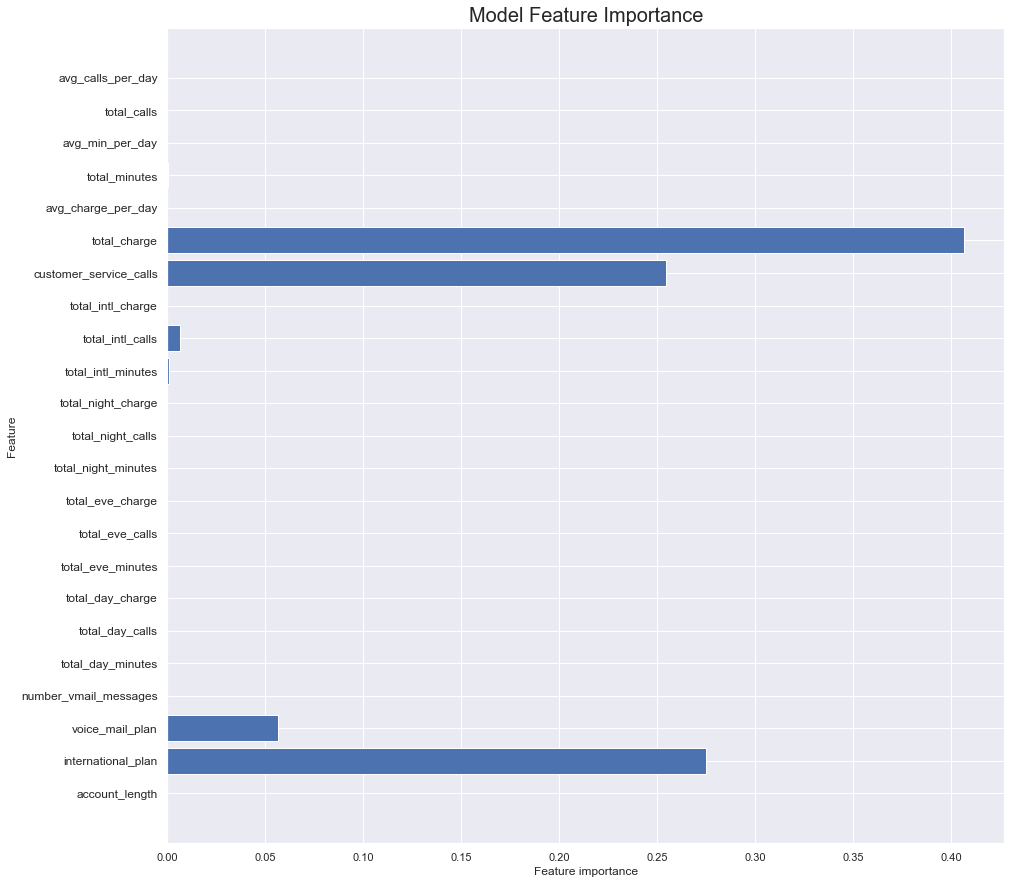

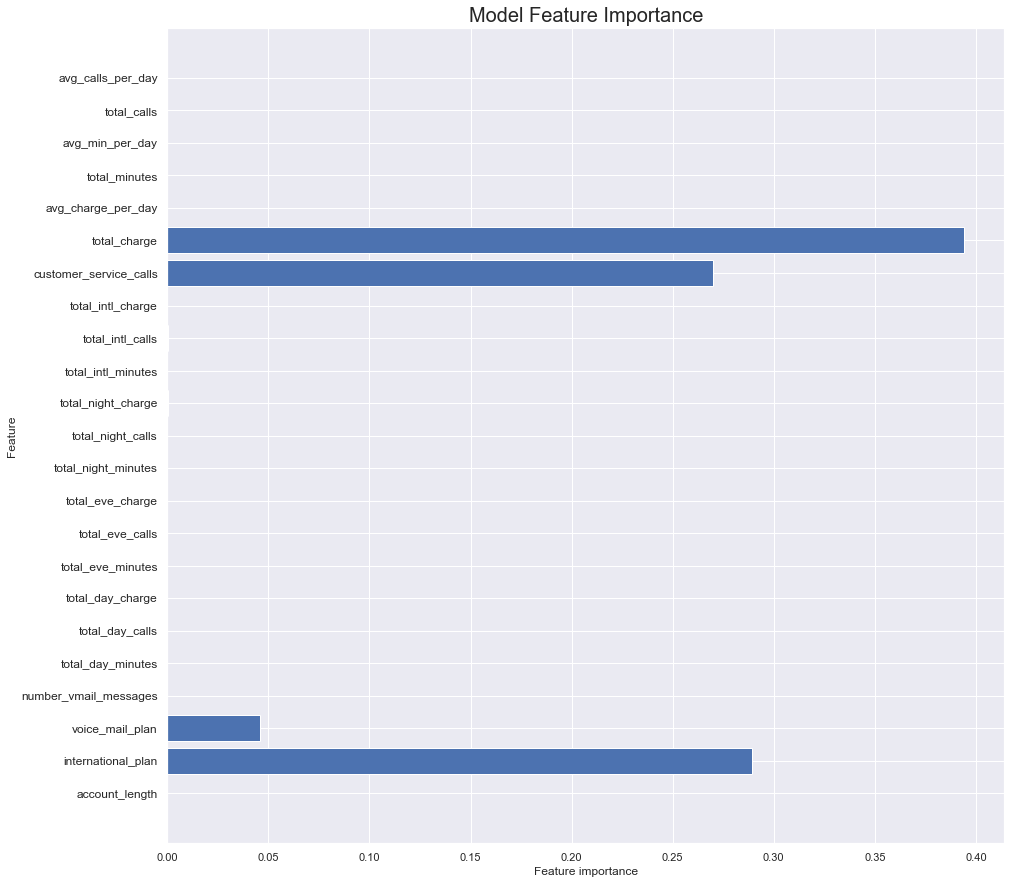

In [142]:
# create list to add recall scores
fold_count=0
for train_ind, val_ind in kf.split(X_train, y_train):
    fold_count+=1

    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    recall = make_scorer(recall_score)

    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    # instantiate and fit/transform scaler
    X_t_sc, X_val_sc = cmpre.ss_scale(X_t, X_val)

    # instantiate and fit SMOTE:
    smote = SMOTE(random_state = 42)
    X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_sc, y_t)
    
    clf = GradientBoostingClassifier(
        loss = 'exponential', 
        learning_rate = 0.01,
        random_state = 15)

    train_cv = cross_val_score(X=X_t_sc_bal, y=y_t_bal, estimator=clf, scoring=recall,cv=10)

    # Predict
    y_pred = clf.fit(X_t_sc_bal, y_t_bal).predict(X_val_sc)

    conf_matrix = confusion_matrix(y_val,y_pred)

    # Store results
    performance.loc['GBC_X4_exp_lr0.01_ss',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_val,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]
    print(performance)
    plot_feature_importances(clf)

In [143]:
X_train_ss, X_test_ss = cmpre.ss_scale(X_train, X_test)

smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)
    
gb = GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, 
                                min_samples_leaf = 0.1, min_samples_split = 0.13636363636363638,
                                random_state = 15)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_ss))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_ss))}')

Train: 0.8631284916201117
Test:  0.888


In [144]:
df_new = df.drop("area_code", axis=1)
df.voice_mail_plan.replace((True, False), (1, 0), inplace = True)
df.international_plan.replace((True, False), (1, 0), inplace = True)
df.churn.replace((True, False), (1, 0), inplace = True)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,False,True,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,False,False,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,False,False,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,True,False,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False
